# Thomas Fire Perimeter Visualization 

## About

**Purpose:**
Here we use historical fire perimeter data from CalFire to obtain the perimeter of the [2017 Thomas Fire](https://www.fire.ca.gov/incidents/2017/12/4/thomas-fire/). The, using provided Landsat imagery and the fire perimeter, we create a map showing the perimeter of the [2017 Thomas Fire](https://www.fire.ca.gov/incidents/2017/12/4/thomas-fire/) in relation to Santa Barbara County.

**Highlights:**
- Cleaning data
- Label-based selection
- Geospatial file creation
- `rioxarray` raster file manipulation 
- True color imagery plotting
- False color imagery plotting

**Dataset Descriptions:** 
The `landsat` data is a simplified collection of bands from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite. This data was retrieved from the [Microsoft Planetary Computer data catalogue](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) and pre-processed to remove data outside land and coarsen the spatial resolution.

California's Fire and Resource Assessment Program (FRAP) maintains a comprehensive database of historical fire perimeters throughout the state, covering both public and private lands. This GIS dataset is updated annually through a collaborative effort between FRAP and several federal agencies - the U.S. Forest Service Region 5, Bureau of Land Management, National Park Service, and Fish and Wildlife Service.

**References:**
- Fire Resource and Assessment Program. (2024). *Historical Fire Perimeters* CalFire. https://www.fire.ca.gov/what-we-do/fire-resource-assessment-program/fire-perimeters
- NASA Landsat 8 (2024). *Landsat Collection 2 Level-2 Science Products* Microsoft Planetary Computer. https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr

In [4]:
# Load fire perimeter data
fire_perimeter = gpd.read_file(os.path.join('data',
                                            'fire23_1.gdb'))
fire_perimeter.head()
fire_perimeter.columns = fire_perimeter.columns.str.lower()

In [6]:
print(f"Fire Perimeter CRS: {fire_perimeter.crs} \nIs this projected?: {fire_perimeter.crs.is_projected}")

Fire Perimeter CRS: epsg:3310 
Is this projected?: True


Here we obtain the coordinate reference system (EPSG:3310) of the fire perimeter data. This CRS is projected.

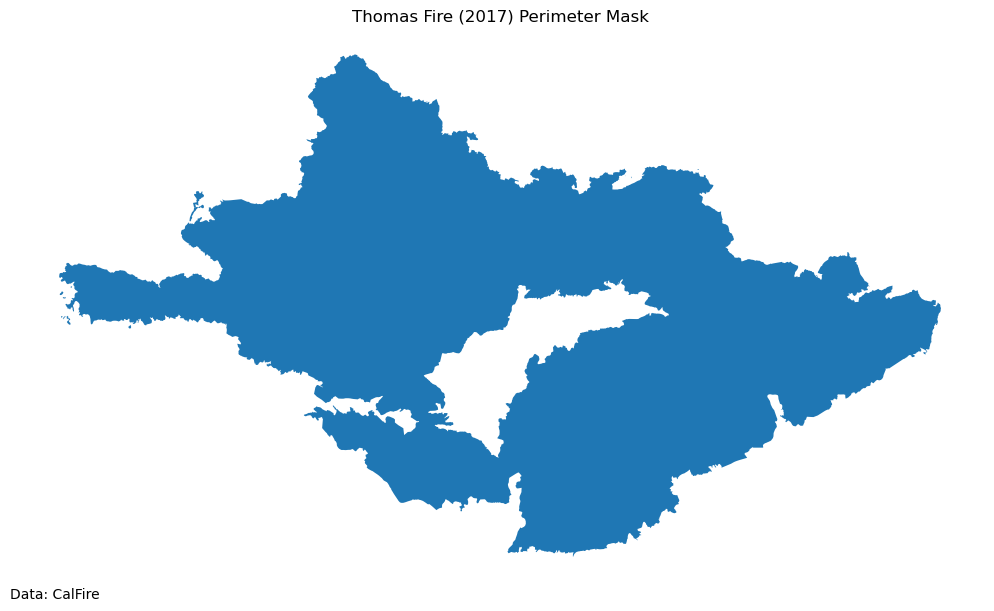

In [8]:
# Filter to the 2017 Thomas Fire
thomasfire = fire_perimeter.loc[(fire_perimeter['fire_name'] == 'THOMAS') & 
                                (fire_perimeter['year_'] == 2017)]

# Plot the perimeter
fig, ax = plt.subplots(figsize = (10,8))
ax.axis('off')
thomasfire.plot(ax=ax)
plt.tight_layout()
plt.subplots_adjust(bottom = 0.05)
ax.set_title('Thomas Fire (2017) Perimeter Mask')
plt.figtext(0.01, 0.15, "Data: CalFire", ha="left", fontsize=10)
plt.show()

In [10]:
# Save file to the data folder in `.geojson` format.
thomasfire.to_file('data/thomasfire.geojson', driver='GeoJSON')

GeoJSON is an open standard format that can represent a variety of geometries.

The landsat data is accessed from workbench-1 at:

`/courses/EDS220/data/hwk4_landsat_data landsat8-2018-01-26-sb-simplified.nc`

In [11]:
# Import data
root = os.path.join('/',
                   'courses',
                   'EDS220',
                   'data',
                   'hwk4_landsat_data')

fp = os.path.join(root, 'landsat8-2018-01-26-sb-simplified.nc')

landsat = rioxr.open_rasterio(fp)

## Preliminary Data Exploration

In [12]:
# Check CRS of data and dimensions
print(
    f"{'Landsat 8 CRS:':<25} {landsat.rio.crs}\n"
    f"{'Is it projected?':<25} {landsat.rio.crs.is_projected}\n"
    f"{'Sizes of dimensions:':<25} {dict(landsat.sizes)}")

Landsat 8 CRS:            EPSG:32611
Is it projected?          True
Sizes of dimensions:      {'y': 731, 'x': 870, 'band': 1}


In [13]:
print(landsat)

<xarray.Dataset>
Dimensions:      (y: 731, x: 870, band: 1)
Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Data variables:
    red          (band, y, x) float64 ...
    green        (band, y, x) float64 ...
    blue         (band, y, x) float64 ...
    nir08        (band, y, x) float64 ...
    swir22       (band, y, x) float64 ...


The landsat dataset has three dimensions: band, x, and y; it has variables for red, green, blue, near infrared 0.8, and short-wave infrared 2,2 bands. The coordinate reference system is EPSG: 32611, and is projected.

In [14]:
# Drop the band dimension of the data
landsat = landsat.squeeze().drop_vars('band')

## True color image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


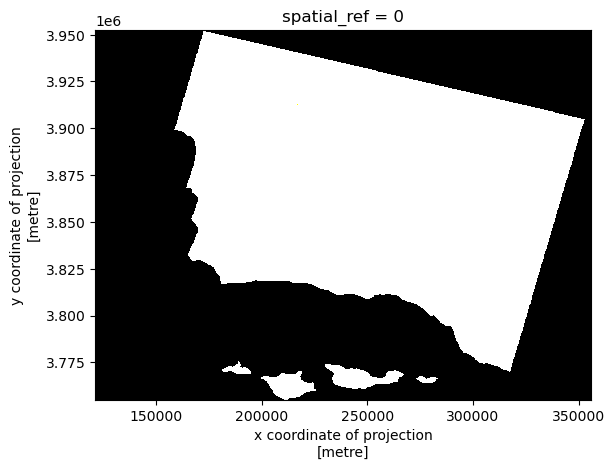

In [15]:
# Select the red, green, and blue vairables of the dataset, then convert to array and plot
landsat[['red', 'green', 'blue']].to_array().plot.imshow()

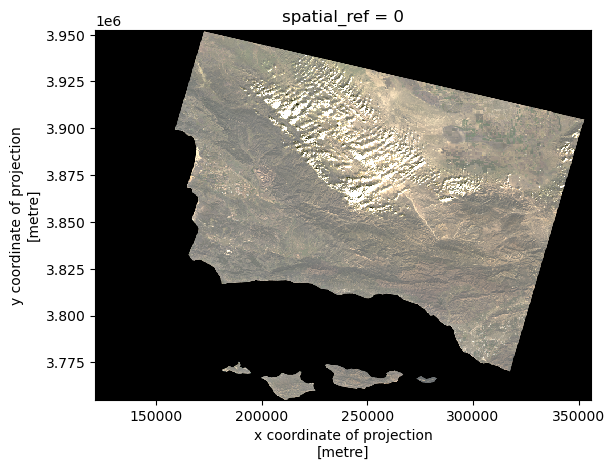

In [16]:
# Set `robust=True` for better color scale while plotting
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust = True)

Passing the `robust=True` parameter in `plt.imshow` prevents outliers from washing out the color scale of the blot. `robust=True` uses the  2nd and 98th percentiles of the data to compute the color limits. The adjusted output takes into account that the RGB values of the clouds are outliers.

## False color image

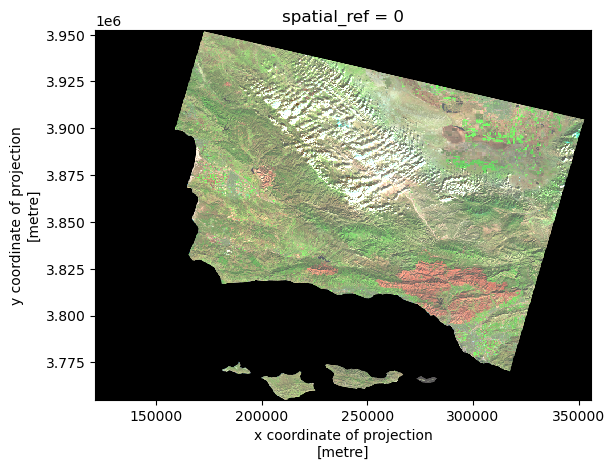

In [17]:
# Create a simple false color image plot using short-wave infrared, near-infrared, and red variables
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)

## Maps 

In [18]:
# Import Thomas Fire perimeter
thomasfire = gpd.read_file(os.path.join('data','thomasfire.geojson'))

# Transform the Landsat CRS to match the fire perimeter CRS
thomasfire.crs
landsat = landsat.rio.reproject("EPSG:3310")
assert landsat.rio.crs == thomasfire.crs

In [19]:
# Create a false color image and clip it for plotting
falsecolor_thomasfire = landsat[['swir22', 'nir08', 'red']].to_array()

falsecolor_clip = falsecolor_thomasfire.rio.clip_box(*thomasfire.total_bounds)

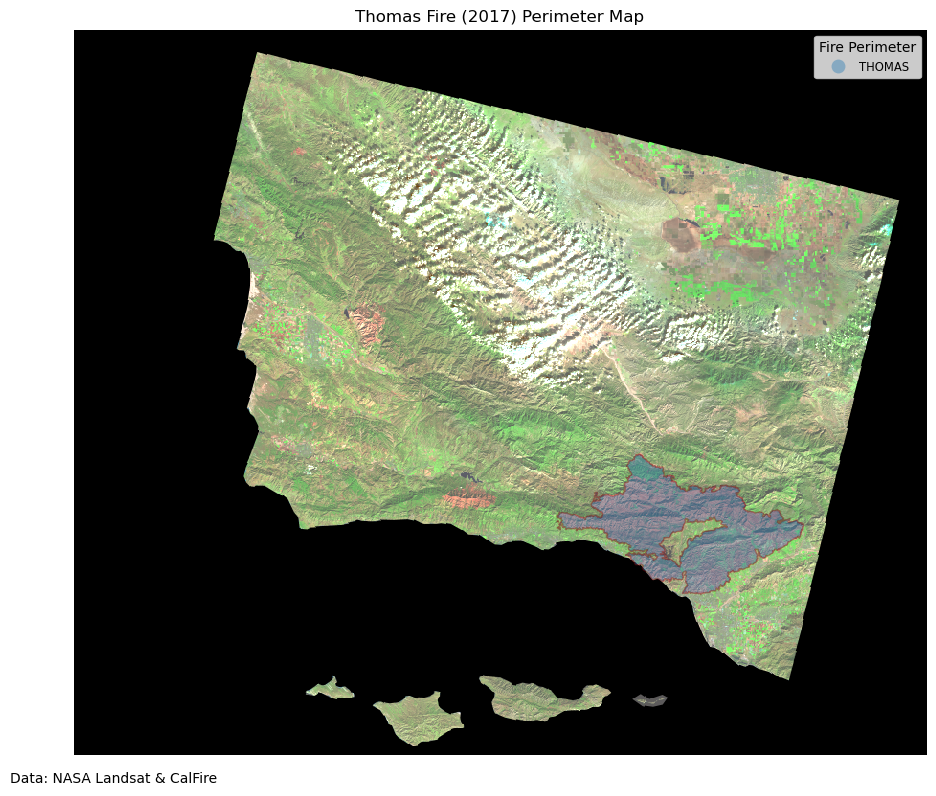

In [20]:
# Create a map showing the false color image together with the Thomas Fire perimeter.
fig, ax = plt.subplots(figsize = (10,8))

ax.axis('off')

falsecolor_thomasfire.plot.imshow(ax = ax,
                                  robust = True)
thomasfire.plot(ax = ax,
                alpha = 0.4,
                column="fire_name",
                edgecolor = 'darkred',
                legend = True,
                legend_kwds={'title': "Fire Perimeter",
                                    'fontsize':'small'})
plt.tight_layout()
plt.subplots_adjust(bottom=0.05)

ax.set_title('Thomas Fire (2017) Perimeter Map')

plt.figtext(0.01, 0.015, "Data: NASA Landsat & CalFire", ha="left", fontsize=10)

plt.show()

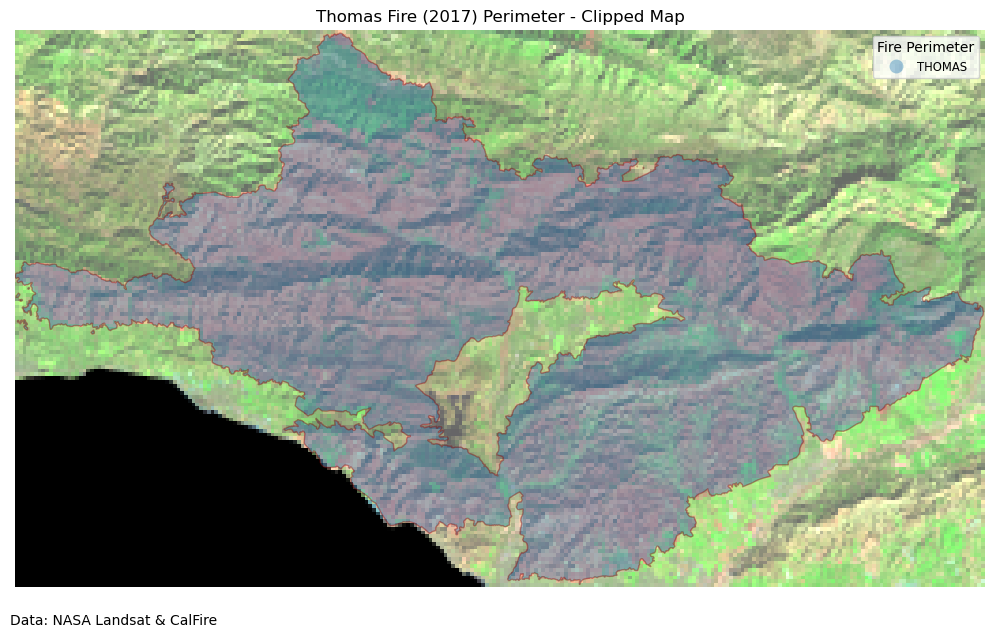

In [21]:
# Create a clipped map showing the false color image and the Thomas Fire perimeter
fig, ax = plt.subplots(figsize = (10,8))

ax.axis('off')

falsecolor_clip.plot.imshow(ax = ax,
                            robust = True)
thomasfire.plot(ax = ax,
                column = "fire_name",
                alpha = 0.4,
                edgecolor = 'darkred',
                legend = True,
                legend_kwds = {'title': "Fire Perimeter", 
                               'fontsize':'small'})

plt.tight_layout()
plt.subplots_adjust(bottom = 0.05)

ax.set_title('Thomas Fire (2017) Perimeter - Clipped Map')

plt.figtext(0.01, 0.12, "Data: NASA Landsat & CalFire", ha="left", fontsize=10)

plt.show()

The above maps use false color satellite imagery to display the burn scar from the 2017 Thomas Fire and its perimeter. Shortwave infrared (SWIR) is plotted in red, near infrared (NIR) in green, and the red band in blue. Newly burned soil reflects SWIR light strongly, and plants containing water reflect NIR strongly, which makes this false color image helpful for visualizing fire effects.